# dict_nGmaps

> Implementation based on dicts

In [1]:
#import IPython

#IPython.Application.instance().kernel.do_shutdown(True) #automatically restarts kernel

In [2]:
# hide
from nbdev.showdoc import *

In [3]:
# export

from collections import defaultdict
from itertools import chain, product
import logging


In [ ]:
from implicit_dict_v2 import implicit_dict
from pixel_map_z_curve_full import D, plot

In [ ]:
# export

class dict_nGmap:
    
    def __init__(self, n):
        
        self.n = n

        """
            A simple instance of the implicit_dict class.
        """
        self.impl_dict = implicit_dict()
        
        """
            Initialization of the set of darts obtained from the implicitly encoding -> Morton code.
        """
        self.darts = D
        #print(self.darts)

        """
            Initialization of custom python dictionaries to handle the involutions of the n-Gmap during the use
            of the Morton code as implicitly encoding. Each alpha represent the ACTIVE part of the data structure,
            i.e., the current n-Gmap.
        """
        self.alpha = [implicit_dict(i) for i in range(n + 1)]

        #self.print_alpha()

        self.marks = defaultdict(lambda:defaultdict(lambda:False))
        # self.marks[index][dart]
        
        """
            Added a tmp dict to create a tmp-Gmap to insert/expand it into the current one.
        """
        self.c = {}


        """
            That variable has the goal of increment itself whenever a new operation is computed
            (removal or contraction).
        """
        self.level = 0

        """
            I want to use the following dictionary to keep trace of the level for each dart in order
            to reconstruct also until a certain level that the user can indicate in input.
        """
        self.dart_level = {}

        """
            Considering the idea behind the implementation, I need to have the PASSIVE part
            according to the canonical encoding. It is represented by the custom alphas.
        """
        self.custom_alpha = [dict() for _ in range(n + 1)]
        
        self.taken_marks = {-1}
        self.lowest_unused_dart_index = 0
        
    @classmethod
    def from_string(cls, string):
        lines = string.strip().split("\n")
        lines = [[int(k) for k in l.split(" ") if k != ""] for l in lines]
    
        return cls.from_list_of_lists(lines)
        
    @classmethod    
    def from_list_of_lists(cls, ll):
        n = len(ll) - 1
        d = len(ll[0])
        
        darts = set(ll[0])
        
        assert all(set(l) == darts for l in ll)
                
        my_nGmap = cls(n)
        my_nGmap.darts.update(darts)
        
        for alpha, l in zip(my_nGmap.alpha, ll):
            for a, b in zip(sorted(darts), l):
                alpha[a] = b
                
        my_nGmap.lowest_unused_dart_index = max(darts) + 1
        
        return my_nGmap
    
    @property
    def is_valid(self):
        """
        checks condition 2 and 3 from definition 1
        (condition 1 is always true as a computer probably has finite memory)
        """
 
        for dart in self.darts:
            for alpha in self.alpha:

                """ print(f'dart -> {dart}')
                print(f'alpha[dart] -> {alpha[dart]}')
                print(f'alpha[alpha[dart]] -> {alpha[alpha[dart]]}') """
                if alpha[alpha[dart]] != dart:
                    return False
            for i in range(0, self.n - 1): # n-1 not included
                alpha1 = self.alpha[i]
                for j in range(i + 2, self.n + 1): # n+1 again not included
                    alpha2 = self.alpha[j]
                    if alpha1[alpha2[alpha1[alpha2[dart]]]] != dart:
                        return False
        return True
    
    def reserve_mark(self):
        """
        algorithm 2
        """
        i = max(self.taken_marks) + 1
        self.taken_marks.add(i)
        return i
    
    def free_mark(self, i):
        """
        algorithm 3
        also includes deleting all these marks, making it safe to call everytime
        """
        del self.marks[i]
        self.taken_marks.remove(i)    
    
    def is_marked(self, d, i):
        """
        algorithm 4
        d ... dart
        i ... mark index
        """
        return self.marks[i][d]
    
    def mark(self, d, i):
        """
        algorithm 5
        d ... dart
        i ... mark index
        """
        self.marks[i][d] = True
        
    def unmark(self, d, i):
        """
        algorithm 6
        d ... dart
        i ... mark index
        """
        # same as bla = False
        del self.marks[i][d]
    
    def mark_all(self, i):
        for d in self.darts:
            self.mark(d, i)
    
    def unmark_all(self, i):
        del self.marks[i]
    
    def ai(self, i, d):
        #print(f'ai -> {self.alpha[i][d]}, i -> {i}, d -> {d}')
        self.alpha[i].set_i(i)
        return self.alpha[i][d]
    
    def set_ai(self, i, d, d1):
        assert 0 <= i <= self.n
        #self.custom_alpha[i][d] = d1
        #print(f'd -> {d}\nd1 -> {d1}')
        #self.dart_level[d] = self.level
        self.alpha[i].set_i(i)
        self.alpha[i][d] = d1
        #print(f'alpha in set_ai -> {self.alpha[i][d]}')
        
    def _remove_dart(self, d):

        """
            We are removing the dart from the set.
        """
        self.darts.remove(d)


        print(f'delete -> {d}')

        """
            We are removing the dart from every alpha
        """
        for i in self.all_dimensions:
            del self.alpha[i][d]
    
    def orbit(self, sequence, d):
        """
        algorithm 7
        sequence ... valid list of dimensional indices
        d ... dart
        """
        print(f'd -> {d}')
        ma = self.reserve_mark()
        self.mark_orbit(sequence, d, ma)
        orbit = self.marks[ma].keys()
        self.free_mark(ma)
        return orbit
    
    def mark_orbit(self, sequence, d, ma):
        """
        used as in algorithm 7 and 8 etc...
        sequence ... valid list of dimension indices
        d ... dart
        ma ... mark to use
        """

        P = [d]
        self.mark(d, ma)
        while P:
            cur = P.pop()
            for i in sequence:
                other = self.alpha[i][cur]
                if not self.is_marked(other, ma):
                    self.mark(other, ma)
                    P.append(other)
    
    def cell_i(self, i, dart):
        """iterator over i-cell of a given dart"""
        return self.orbit(self.all_dimensions_but_i(i), dart)

    def cell_0(self, dart):
        return self.cell_i(0, dart)
    def cell_1(self, dart):
        return self.cell_i(1, dart)
    def cell_2(self, dart):
        return self.cell_i(2, dart)
    def cell_3(self, dart):
        return self.cell_i(3, dart)
    def cell_4(self, dart):
        return self.cell_i(4, dart)
    
    def no_i_cells (self, i=None):
        """
        Counts
            i-cells,             if 0 <= i <= n
            connected components if i is None
        """
        assert i is None or 0 <= i <= self.n
        # return more_itertools.ilen (self.darts_of_i_cells(i))
        return sum ((1 for d in self.darts_of_i_cells(i)))

    @property
    def no_0_cells (self): return self.no_i_cells (0)
    @property
    def no_1_cells (self): return self.no_i_cells (1)
    @property
    def no_2_cells (self): return self.no_i_cells (2)
    @property
    def no_3_cells (self): return self.no_i_cells (3)
    @property
    def no_4_cells (self): return self.no_i_cells (4)
    @property
    def no_ccs     (self): return self.no_i_cells ( )
    
    def darts_of_i_cells(self, i = None):
        """
        algorithm 8
        """
        ma = self.reserve_mark()
        try:
            for d in self.darts:
                if not self.is_marked(d, ma):
                    yield d
                    self.mark_orbit(self.all_dimensions_but_i(i), d, ma)
        finally:
            self.free_mark(ma)
    
    def all_i_cells(self, i = None):
        for d in self.darts_of_i_cells(i):
            yield self.cell_i(i, d)
    
    def all_conected_components(self):
        return self.all_i_cells()
    
    def darts_of_i_cells_incident_to_j_cell(self, d, i, j):
        """
        algorithm 9
        """
        assert i != j
        ma = self.reserve_mark()
        try:
            for e in self.orbit(self.all_dimensions_but_i(j), d):
                if not self.is_marked(e, ma):
                    yield e
                    self.mark_orbit(self.all_dimensions_but_i(j), e, ma)
        finally:
            self.free_mark(ma)
        
    def darts_of_i_cells_adjacent_to_i_cell(self, d, i):
        """
        algorithm 10
        """
        ma = self.reserve_mark()
        try:
            for e in self.orbit(self.all_dimensions_but_i(i), d):
                f = self.alpha[i][e]
                if not self.is_marked(f, ma):
                    yield f
                    self.mark_orbit(self.all_dimensions_but_i(i), f, ma)
        finally:
            self.free_mark(ma)
        
    def all_dimensions_but_i (self, i=None):
        """Return a sorted sequence [0,...,n], without i, if 0 <= i <= n"""
        assert i is None or 0 <= i <= self.n
        return [j for j in range (self.n+1) if j != i]
    
    @property
    def all_dimensions(self):
        return self.all_dimensions_but_i()
    
    def is_i_free(self, i, d):
        """
        definiton 2 / algorithm 11
        """
        return self.alpha[i][d] == d
        
    def is_i_sewn_with(self, i, d):
        """
        definiton 2
        """
        d2 = self.alpha[i][d]
        return d != d2, d2
    
    def create_dart(self):
        """
        algorithm 12
        """
        d = self.lowest_unused_dart_index
        self.lowest_unused_dart_index += 1
        self.darts.add(d)
        for alpha in self.alpha:
            alpha[d] = d
        return d
    
    def remove_isolated_dart(self, d):
        """
        algorithm 13
        """
        assert self.is_isolated(d)
        self.remove_isolated_dart_no_assert(d)
        
    def remove_isolated_dart_no_assert(self, d):
        self.darts.remove(d)
        for alpha in self.alpha:
            del alpha[d]
    
    def is_isolated(self, d):
        for i in range(self.n + 1):
            if not self.is_i_free(i, d):
                return False
        return True
    
    def increase_dim(self):
        """
        algorithm 15 in place
        """
        self.n += 1
        self.alpha.append(dict((d,d) for d in self.darts))
        
    def decrease_dim(self):
        """
        algorithm 16 in place
        """
        assert all(self.is_i_free(self.n, d) for d in self.darts)
        self.decrease_dim_no_assert()
    
    def decrease_dim_no_assert(self):
        del self.alpha[self.n]
        self.n -= 1
    
    def index_shift(self, by):
        self.darts = {d + by for d in self.darts}
        self.alpha = [{k + by : v + by for k, v in a.items()} for a in self.alpha]
        for mark in self.marks:
            new_dict = {key + by : value for key, value in self.marks[mark].items()}
            self.marks[mark].clear()
            self.marks[mark].update(new_dict) #this is done to preserve default dicts
        self.lowest_unused_dart_index += by
        
    def merge(self, other):
        """
        algorithm 17 in place
        """
        assert self.n == other.n
        self.taken_marks.update(other.taken_marks)
        shift = max(self.darts) - min(other.darts) + 1
        other.index_shift(shift)
        
        self.darts.update(other.darts)
        for sa, oa in zip(self.alpha, other.alpha):
            sa.update(oa)
        for mk in other.marks:
            self.marks[mk].update(other.marks[mk])
        self.taken_marks.update(other.taken_marks)
        self.lowest_unused_dart_index = other.lowest_unused_dart_index
        
    def restrict(self, D):
        """
        algorithm 18
        """
        raise NotImplementedError #boring
    
    def sew_seq(self, i):
        """
        indices used in the sewing operations
        (0, ..., i - 2, i + 2, ..., n)
        """
        return chain(range(0, i - 1), range(i + 2, self.n + 1))
    
    def sewable(self, d1, d2, i):
        """
        algorithm 19
        tests wether darts d1, d2 are sewable along i
        returns bool
        """
        if d1 == d2 or not self.is_i_free(i, d1) or not self.is_i_free(i, d2):
            return False
        try:
            f = dict()
            for d11, d22 in strict_zip(self.orbit(self.sew_seq(i), d1), self.orbit(self.sew_seq(i), d2), strict = True):
                f[d11] = d22
                for j in self.sew_seq(i):
                    if self.alpha[j][d11] in f and f[self.alpha[j][d11]] != self.alpha[j][d22]:
                        return False
        except ValueError: #iterators not same length
            return False
        return True
    
    def sew(self, d1, d2, i):
        """
        algorithm 20
        """
        assert self.sewable(d1, d2, i)
        self.sew_no_assert(d1, d2, i)
        
    def sew_no_assert(self, d1, d2, i):
        for e1, e2 in strict_zip(self.orbit(self.sew_seq(i), d1), self.orbit(self.sew_seq(i), d2), strict = True):
            self.alpha[i][e1] = e2
            self.alpha[i][e2] = e1
    
    def unsew(self, d, i):
        """
        algorithm 21
        """
        assert not self.is_i_free(i, d)
        for e in self.orbit(self.sew_seq(i), d):
            f = self.alpha[i][e]
            self.alpha[i][f] = f
            self.alpha[i][e] = e
    
    def incident (self, i, d1, j, d2):
        """
        checks wether the i-cell of d1 is incident to the j-cell of d2
        """
        for e1, e2 in product(self.cell_i(i, d1), self.cell_i(j, d2)):
            if e1 == e2:
                return True
        return False
    
    def adjacent(self, i, d1, d2):
        """
        checks wether the i-cell of d1 is adjacent to the i-cell of d2
        """
        first_cell = self.cell_i(i, d1)
        second_cell = set(self.cell_i(i, d2))
        for d in first_cell:
            if self.alpha[i][d] in second_cell:
                return True
        return False
    
    # Contractablilty & Removability

    """
        The next three methods are useful for checking the contractability and removability of darts.
    """
    
    def _is_i_removable_or_contractible(self, i, dart, rc):
        """
        Test if an i-cell of dart is removable/contractible:

        i    ... i-cell
        dart ... dart
        rc   ... +1 => removable test, -1 => contractible test
        """
        assert dart in self.darts
        assert 0 <= i <= self.n
        assert rc in {-1, +1}

        if rc == +1:  # removable test
            if i == self.n  : return False
            if i == self.n-1: return True
        if rc == -1:  # contractible test
            if i == 0: return False
            if i == 1: return True

        for d in self.cell_i(i, dart):
            if self.alpha[i+rc][self.alpha[i+rc+rc][d]] != self.alpha[i+rc+rc][self.alpha[i+rc][d]]:
                return False
        return True

    def is_i_removable(self, i, dart):
        """True if i-cell of dart can be removed"""
        return self._is_i_removable_or_contractible(i, dart, rc=+1)

    def is_i_contractible(self, i, dart):
        """True if i-cell of dart can be contracted"""
        return self._is_i_removable_or_contractible(i, dart, rc=-1)

    """
        The i_remove_contract method is used for removing a certain dart from the n-Gmap.
    """
    
    def _i_remove_contract(self, i, dart, rc, skip_check=False):
        """
        Remove / contract an i-cell of dart
        d  ... dart
        i  ... i-cell
        rc ... +1 => remove, -1 => contract
        skip_check ... set to True if you are sure you can remove / contract the i-cell
        """
        logging.debug (f'{"Remove" if rc == 1 else "Contract"} {i}-Cell of dart {dart}')

        if not skip_check:
            assert self._is_i_removable_or_contractible(i, dart, rc),\
                f'{i}-cell of dart {dart} is not {"removable" if rc == 1 else "contractible"}!'

        """
            Every time the checking is over I assume that I can increment the variable that keeps trace of
            the levels because the dart is removed/contracted, for sure.
        """
        self.level += 1
        #print(f'level -> {self.level}')

        
        #print(type(self.alpha[i]))

        i_cell = set(self.cell_i(i, dart))  # mark all the darts in ci(d)

        #print(f'i-cell -> {i_cell}')
        #print(f'\n{i}-cell to be removed {i_cell}')
        for d in i_cell:
            d1 = self.ai (i,d) # d1 ← d.Alphas[i];
            if d1 not in i_cell:  # if not isMarkedNself(d1,ma) then
                # d2 ← d.Alphas[i + 1].Alphas[i];
                print(f'd1 -> {d1}')
                d2 = self.ai (i+rc,d)
                d2 = self.ai (i   ,d2)
                while d2 in i_cell: # while isMarkedNself(d2,ma) do
                    # d2 ← d.Alphas[i + 1].Alphas[i];
                    d2 = self.ai (i+rc,d2)
                    d2 = self.ai (i   ,d2)
                logging.debug (f'Modifying alpha_{i} of dart {d1} from {self.ai (i,d1)} to {d2}')

                self.set_ai(i,d1,d2) # d1.Alphas[i] ← d2;

        
        """
            In that for loop, in addition to remove the dart given in input,
            I also check if involutions of this dart are different from the
            implicitly ones. If they are different, then they will move into
            the passive part, otherwise nothing will be stored.

            I wanto to say that implementation is been provided to work with
            2-Gmaps. For that reason there are only three if statements to check
            which j-value I am analysing.
        """
        for d in i_cell:  # foreach dart d' ∈ ci(d) do
            for j in self.all_dimensions:
                if j == 0:
                    if self.alpha[j][d] != self.alpha[j].get_alpha0(d):
                        self.custom_alpha[j][d] = self.alpha[j][d]

                if j == 1:
                    if self.alpha[j][d] != self.alpha[j].get_alpha1(d):
                        self.custom_alpha[j][d] = self.alpha[j][d]

                if j == 2:
                    if self.alpha[j][d] != self.alpha[j].get_alpha2(d):
                        self.custom_alpha[j][d] = self.alpha[j][d]
                
            self.dart_level[d] = self.level

            print(f'dart that will be removed -> {d}')
            self._remove_dart (d)  # remove d' from gm.Darts;

    """
        Method I need to call to remove a certain dart from the n-Gmap.
    """
    def _remove(self, i, dart, skip_check=False):
        """Remove i-cell of dart"""
        self._i_remove_contract(i, dart, rc=+1, skip_check=skip_check)

    """
        Method I need to call to contract a certain dart from the n-Gmap.
    """
    def _contract(self, i, dart, skip_check=False):
        """Contract i-cell of dart"""
        self._i_remove_contract(i, dart, rc=-1, skip_check=skip_check)

    """
        Useful method to have the summary of the current n-Gmap.
    """
    def __repr__(self):
        out = f"{self.n}dGmap of {len(self.darts)} darts:\n"
        for i in range(self.n + 1): # n+1 is not included
            out += f" {i}-cells: {self.no_i_cells(i)}\n"
        out += f" ccs: {self.no_ccs}"
        return out


    """
        Method to check the initial involutions of the n-Gmap.
    """
    def print_starting_alpha(self):

        print(f'\nD[i]    | ', end= " ")
        for i in self.darts:
            print(f'{i} |', end= " ")

        for i in range(0, self.n+1):
            print(f'\nAlpha_{i} | ', end= " ")
            for k in self.darts:
                if i == 0:
                    print(f'{self.impl_dict.get_alpha0(k)} |', end= " ")
                elif i == 1:
                    print(f'{self.impl_dict.get_alpha1(k)} |', end= " ")
                else:
                    print(f'{self.impl_dict.get_alpha2(k)} |', end= " ")


    """
        Method to print the active part (current Gmap) that is stored into the data structure.
    """
    def print_alpha(self):
        for i in range(0, self.n + 1):
            print(f'\nAlpha_{i} -> {self.alpha[i]}')

    
    def print_final_alpha(self):
        
        print(f'\nD[i]    | ', end= " ")
        for i in self.darts:
            print(f'{i} |', end= " ")

        for i in range(0, self.n+1):
            print(f'\nAlpha_{i} | ', end= " ")
            for k in self.darts:
                if i == 0:
                    print(f'{self.alpha[i][k]} |', end= " ")
                elif i == 1:
                    print(f'{self.alpha[i][k]} |', end= " ")
                else:
                    print(f'{self.alpha[i][k]} |', end= " ")
        
    """
        Method to print the passive part that is stored into the data structure.
    """
    def print_custom(self):
        """ print(f'\n\nDart    | ', end= " ")
        for i in self.custom_alpha[0].keys():
            print(f'{i} |', end= " ")

        for i in range(0, self.n+1):
            print(f'\nAlpha_{i} | ', end= " ")
            for j in self.custom_alpha[i].values():
                    print(f'{j} |', end= " ") """

        print(self.custom_alpha[0])
        print(self.custom_alpha[1])
        print(self.custom_alpha[2])

    """
        Method to check the history of the pyramid.
    """
    def print_history_levels(self):
        print(f'\n\nHistory')

        print(f'Dart  | Level')

        for k, v in zip(self.dart_level.keys(), self.dart_level.values()):
            print(f'  {k}   |   {v}')



    def _insert_until_level(self, level, filename=None, i=None,):   

        l = []
        for k in reversed(self.dart_level):
            
            if self.dart_level[k] > level:
                """
                    If you over this condition It means you can reconstruct something.
                """
                l.append(k)
                self.darts.add(k)
                print(f'dart {k} added to the set of darts')

                for j in range(0, self.n + 1):
                        # k = 75
                        try:
                            self.alpha[j][self.custom_alpha[j][k]] = k
                        except KeyError:
                            self.alpha[j].set_i(j)
                            self.alpha[j][self.alpha[j][k]] = k ############################## alpha0[alpha0[75] -> 74] = 75

                        try:
                            
                            self.alpha[j][k] = self.custom_alpha[j][k]
                        except KeyError:
                            if j == 0:
                                if self.alpha[j][k] != self.alpha[j].get_alpha0(k):
                                    #self.alpha[j][k] = self.alpha[j][k] ################## alpha0[75] = implicitly_encoding, actually
                                    self.alpha[j][k] = self.alpha[j].get_alpha0(k)

                            if j == 1:
                                if self.alpha[j][k] != self.alpha[j].get_alpha1(k):
                                    self.alpha[j][k] = self.alpha[j].get_alpha1(k)

                            if j == 2:
                                if self.alpha[j][k] != self.alpha[j].get_alpha2(k):
                                    self.alpha[j][k] = self.alpha[j].get_alpha2(k)

                        try:
                            del self.custom_alpha[j][k]
                        except KeyError:
                            del self.alpha[j][self.alpha[j][k]]
                
        for el in l:
            del self.dart_level[el]

    def plot(self):
        plot(self.darts)
                
def strict_zip(arg1, arg2, strict = False):
    """
    strict keyword for zip is only avaliable in python 3.10 which is still in alpha :(
    """
    assert strict == True
    arg1 = list(arg1)
    arg2 = list(arg2)
    if len(arg1) == len(arg2):
        return zip(arg1, arg2)
    else:
        raise ValueError

    

# Carmine test: compare the results of that implementation with mine

In [ ]:
from combinatorial.notebooks.combinatorial.zoo import G2_HOUSE_1, G2_TWO_TRIANGLES_1

#m = dict_nGmap.from_string(G2_TWO_TRIANGLES_1)
m = dict_nGmap(2)



In [ ]:
m

2dGmap of 48 darts:
 0-cells: 9
 1-cells: 12
 2-cells: 5
 ccs: 1

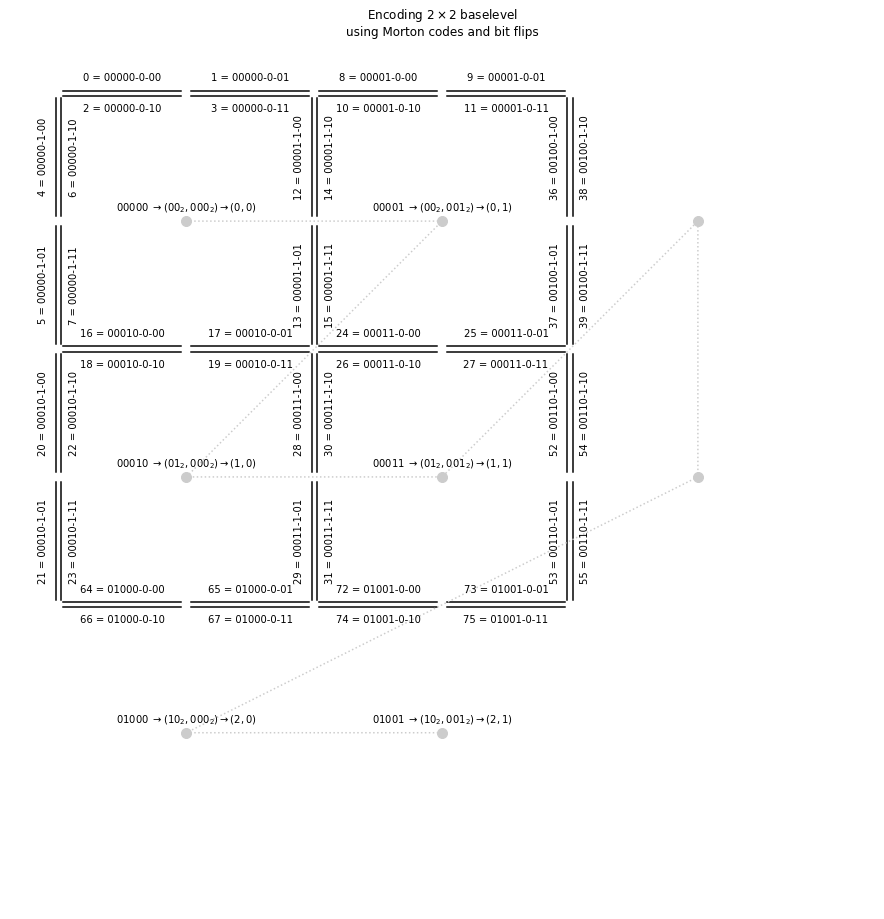

In [ ]:
m.plot()

In [ ]:
m.print_starting_alpha()


D[i]    |  0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 | 21 | 22 | 23 | 24 | 25 | 26 | 27 | 28 | 29 | 30 | 31 | 36 | 37 | 38 | 39 | 52 | 53 | 54 | 55 | 64 | 65 | 66 | 67 | 72 | 73 | 74 | 75 | 
Alpha_0 |  1 | 0 | 3 | 2 | 5 | 4 | 7 | 6 | 9 | 8 | 11 | 10 | 13 | 12 | 15 | 14 | 17 | 16 | 19 | 18 | 21 | 20 | 23 | 22 | 25 | 24 | 27 | 26 | 29 | 28 | 31 | 30 | 37 | 36 | 39 | 38 | 53 | 52 | 55 | 54 | 65 | 64 | 67 | 66 | 73 | 72 | 75 | 74 | 
Alpha_1 |  4 | 8 | 6 | 12 | 0 | 20 | 2 | 16 | 1 | 38 | 14 | 36 | 3 | 17 | 10 | 24 | 7 | 13 | 22 | 28 | 5 | 66 | 18 | 64 | 15 | 37 | 30 | 52 | 19 | 65 | 26 | 72 | 11 | 25 | 9 | 54 | 27 | 73 | 39 | 75 | 23 | 29 | 21 | 74 | 31 | 53 | 67 | 55 | 
Alpha_2 |  2 | 3 | 0 | 1 | 6 | 7 | 4 | 5 | 10 | 11 | 8 | 9 | 14 | 15 | 12 | 13 | 18 | 19 | 16 | 17 | 22 | 23 | 20 | 21 | 26 | 27 | 24 | 25 | 30 | 31 | 28 | 29 | 38 | 39 | 36 | 37 | 54 | 55 | 52 | 53 | 66 | 67 | 64 | 65 | 74 | 75 | 72 | 73 | 

In [ ]:
print(m.darts)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 36, 37, 38, 39, 52, 53, 54, 55, 64, 65, 66, 67, 72, 73, 74, 75}


In [ ]:
m._remove(0, 2)
m.is_valid

d -> 2
d -> 2
d1 -> 1
d1 -> 3
d1 -> 5
d1 -> 7
dart that will be removed -> 0
delete -> 0
dart that will be removed -> 2
delete -> 2
dart that will be removed -> 4
delete -> 4
dart that will be removed -> 6
delete -> 6


True

In [ ]:
m.print_custom()
m.print_history_levels()

{}
{}
{}


History
Dart  | Level
  0   |   1
  2   |   1
  4   |   1
  6   |   1


In [ ]:
m.print_alpha()
print(m.darts)


Alpha_0 -> {1: 5, 3: 7, 5: 1, 7: 3}

Alpha_1 -> {}

Alpha_2 -> {}
{1, 3, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 36, 37, 38, 39, 52, 53, 54, 55, 64, 65, 66, 67, 72, 73, 74, 75}


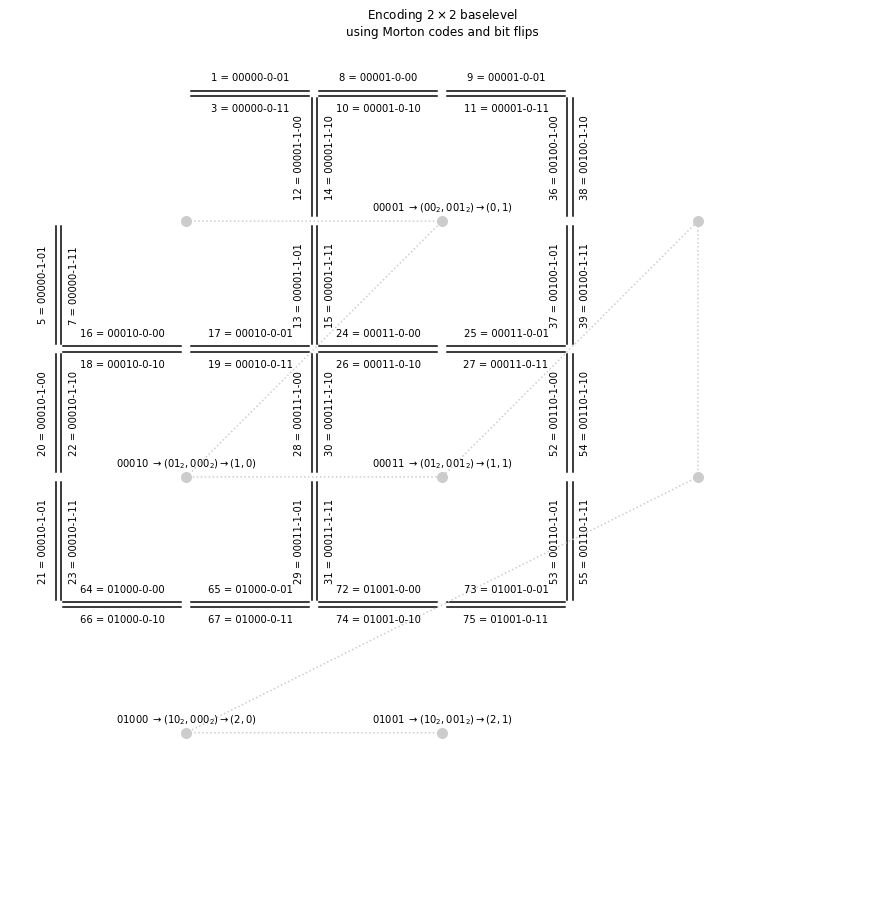

In [ ]:
m.plot()

In [ ]:
m._remove(1, 12)

d -> 12
d1 -> 3
d1 -> 17
d1 -> 10
d1 -> 24
dart that will be removed -> 12
delete -> 12
dart that will be removed -> 13
delete -> 13
dart that will be removed -> 14
delete -> 14
dart that will be removed -> 15
delete -> 15


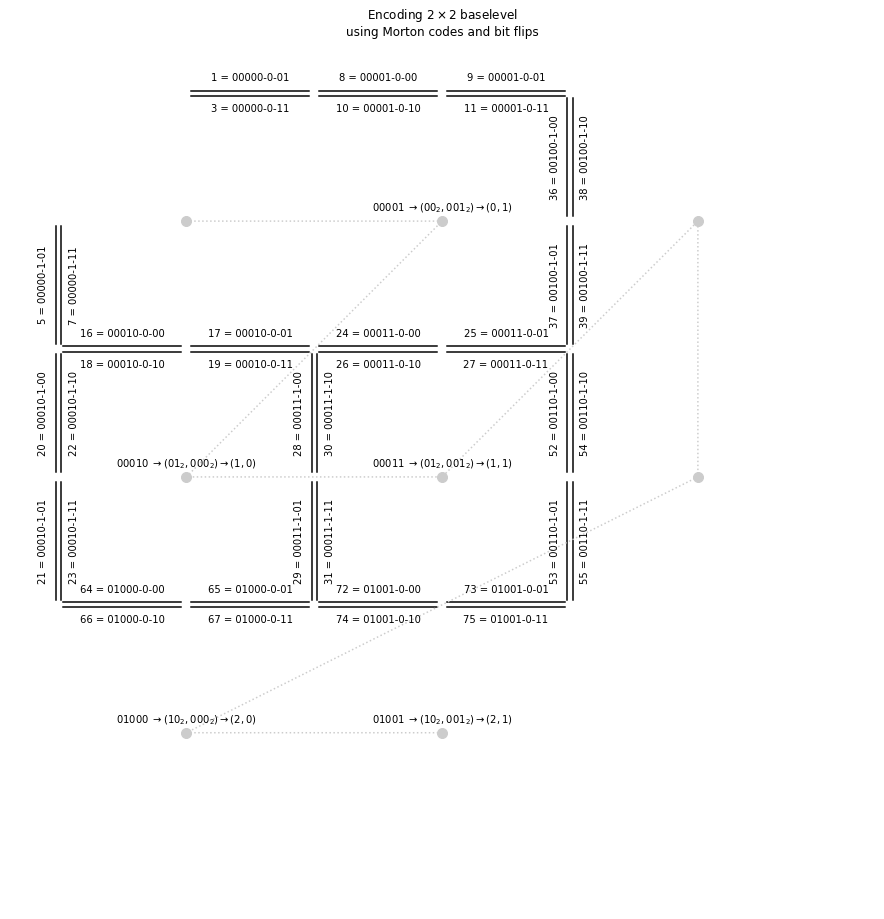

In [ ]:
m.plot()

In [ ]:
m.print_custom()
m.print_alpha()
m.print_history_levels()

{}
{}
{}

Alpha_0 -> {1: 5, 3: 7, 5: 1, 7: 3}

Alpha_1 -> {3: 10, 17: 24, 10: 3, 24: 17}

Alpha_2 -> {}


History
Dart  | Level
  0   |   1
  2   |   1
  4   |   1
  6   |   1
  12   |   2
  13   |   2
  14   |   2
  15   |   2


In [ ]:
print(m.darts)

{1, 3, 5, 7, 8, 9, 10, 11, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 36, 37, 38, 39, 52, 53, 54, 55, 64, 65, 66, 67, 72, 73, 74, 75}


d -> 1
d -> 1
d1 -> 9
d1 -> 5
d1 -> 11
d1 -> 7
dart that will be removed -> 8
delete -> 8
dart that will be removed -> 1
delete -> 1
sto cancellando...
dart that will be removed -> 10
delete -> 10
sto cancellando...
dart that will be removed -> 3
delete -> 3
sto cancellando...
sto cancellando...


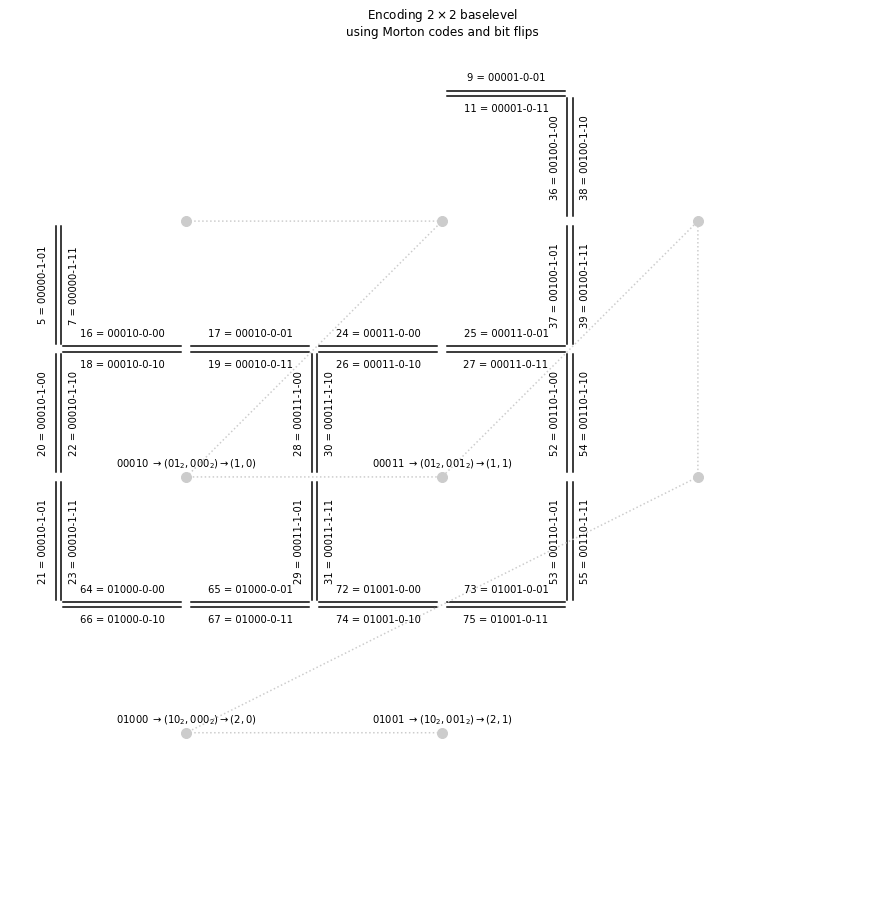

In [ ]:
m._remove(0, 1)
m.plot()

In [ ]:
m.print_custom()
m.print_alpha()
m.print_history_levels()

{1: 5, 3: 7}
{10: 3, 3: 10}
{}

Alpha_0 -> {5: 9, 7: 11, 9: 5, 11: 7}

Alpha_1 -> {17: 24, 24: 17}

Alpha_2 -> {}


History
Dart  | Level
  0   |   1
  2   |   1
  4   |   1
  6   |   1
  12   |   2
  13   |   2
  14   |   2
  15   |   2
  8   |   3
  1   |   3
  10   |   3
  3   |   3


In [ ]:
m._contract(1, 72)
m.is_valid

d -> 72
d1 -> 31
d1 -> 53
d1 -> 67
d1 -> 55
dart that will be removed -> 72
delete -> 72
dart that will be removed -> 73
delete -> 73
dart that will be removed -> 74
delete -> 74
dart that will be removed -> 75
delete -> 75


True

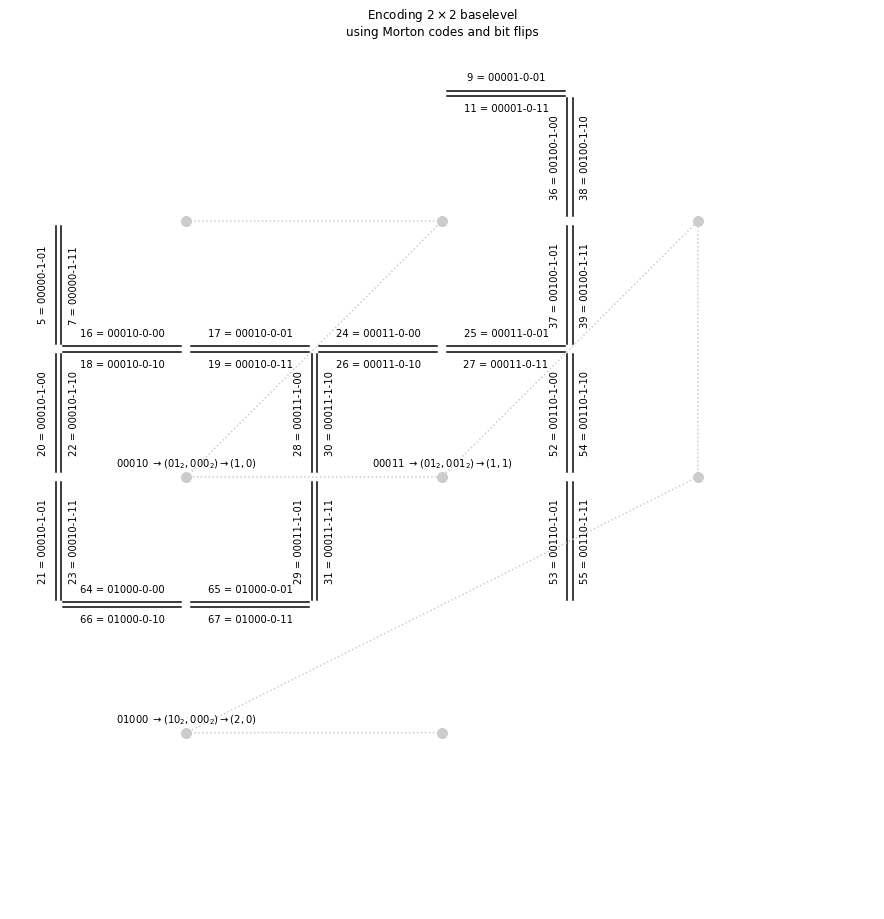

In [ ]:
m.plot()

In [ ]:
m.print_custom()
m.print_history_levels()

{1: 5, 3: 7}
{10: 3, 3: 10}
{}


History
Dart  | Level
  0   |   1
  2   |   1
  4   |   1
  6   |   1
  12   |   2
  13   |   2
  14   |   2
  15   |   2
  8   |   3
  1   |   3
  10   |   3
  3   |   3
  72   |   4
  73   |   4
  74   |   4
  75   |   4


In [ ]:
m.print_alpha()


Alpha_0 -> {5: 9, 7: 11, 9: 5, 11: 7}

Alpha_1 -> {17: 24, 24: 17, 31: 53, 53: 31, 67: 55, 55: 67}

Alpha_2 -> {}


In [ ]:
print(m.darts)

{5, 7, 9, 11, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 36, 37, 38, 39, 52, 53, 54, 55, 64, 65, 66, 67}


In [ ]:
m

2dGmap of 32 darts:
 0-cells: 6
 1-cells: 8
 2-cells: 4
 ccs: 1

In [ ]:
"""
    You can give in input the level of the pyramid until you want to reconstruct. This value is escluded from the considered interval of levels.
    Ex. INPUT = 1 -> level belong to ]1, top]
"""
m._insert_until_level(0, 'implicit_involutions')

dart 75 added to the set of darts
sto cancellando...
dart 74 added to the set of darts
sto cancellando...
dart 73 added to the set of darts
sto cancellando...
dart 72 added to the set of darts
sto cancellando...
dart 3 added to the set of darts
dart 10 added to the set of darts
sto cancellando...
dart 1 added to the set of darts
dart 8 added to the set of darts
sto cancellando...
dart 15 added to the set of darts
sto cancellando...
dart 14 added to the set of darts
sto cancellando...
dart 13 added to the set of darts
sto cancellando...
dart 12 added to the set of darts
sto cancellando...
dart 6 added to the set of darts
sto cancellando...
dart 4 added to the set of darts
sto cancellando...
dart 2 added to the set of darts
sto cancellando...
dart 0 added to the set of darts
sto cancellando...


In [ ]:
m.print_alpha()

print('\n')
m.print_custom()

m.print_history_levels()

print('\nSet of the darts')
print(sorted(m.darts))


Alpha_0 -> {}

Alpha_1 -> {}

Alpha_2 -> {}


{}
{}
{}


History
Dart  | Level

Set of the darts
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 36, 37, 38, 39, 52, 53, 54, 55, 64, 65, 66, 67, 72, 73, 74, 75]


In [ ]:
m

2dGmap of 48 darts:
 0-cells: 9
 1-cells: 12
 2-cells: 5
 ccs: 1

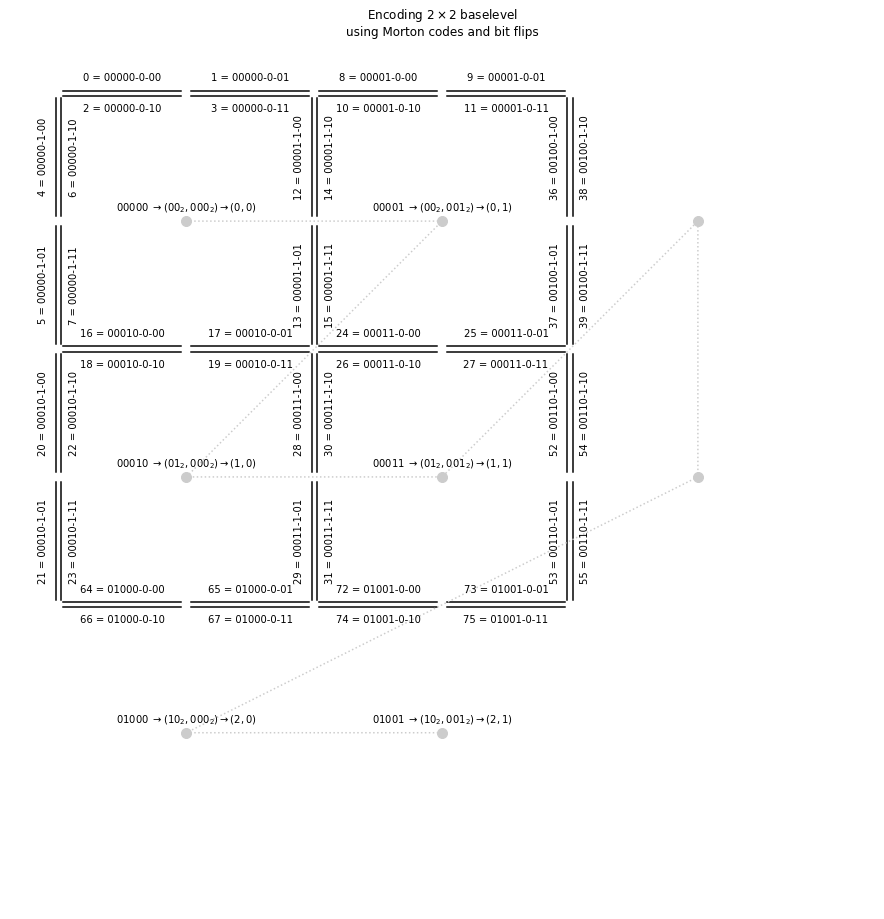

In [ ]:
m.plot()

In [ ]:
m.print_final_alpha()


D[i]    |  5 | 7 | 9 | 11 | 16 | 17 | 18 | 19 | 20 | 21 | 22 | 23 | 24 | 25 | 26 | 27 | 28 | 29 | 30 | 31 | 1 | 6 | 0 | 36 | 37 | 38 | 39 | 8 | 10 | 52 | 53 | 54 | 55 | 2 | 12 | 64 | 65 | 66 | 67 | 13 | 14 | 75 | 74 | 73 | 72 | 15 | 3 | 4 | 
Alpha_0 |  4 | 6 | 8 | 10 | 17 | 16 | 19 | 18 | 21 | 20 | 23 | 22 | 25 | 24 | 27 | 26 | 29 | 28 | 31 | 30 | 0 | 7 | 1 | 37 | 36 | 39 | 38 | 9 | 11 | 53 | 52 | 55 | 54 | 3 | 13 | 65 | 64 | 67 | 66 | 12 | 15 | 74 | 75 | 72 | 73 | 14 | 2 | 5 | 
Alpha_1 |  20 | 16 | 38 | 36 | 7 | 13 | 22 | 28 | 5 | 66 | 18 | 64 | 15 | 37 | 30 | 52 | 19 | 65 | 26 | 72 | 8 | 2 | 4 | 11 | 25 | 9 | 54 | 1 | 14 | 27 | 73 | 39 | 75 | 6 | 3 | 23 | 29 | 21 | 74 | 17 | 10 | 55 | 67 | 53 | 31 | 24 | 12 | 0 | 
Alpha_2 |  7 | 5 | 11 | 9 | 18 | 19 | 16 | 17 | 22 | 23 | 20 | 21 | 26 | 27 | 24 | 25 | 30 | 31 | 28 | 29 | 3 | 4 | 2 | 38 | 39 | 36 | 37 | 10 | 8 | 54 | 55 | 52 | 53 | 0 | 14 | 66 | 67 | 64 | 65 | 15 | 12 | 73 | 72 | 75 | 74 | 13 | 1 | 6 | 

In [ ]:
m

2dGmap of 48 darts:
 0-cells: 9
 1-cells: 12
 2-cells: 5
 ccs: 1

# Test using another Gmap

In [ ]:
m1 = dict_nGmap(2)

m1

2dGmap of 48 darts:
 0-cells: 9
 1-cells: 12
 2-cells: 5
 ccs: 1

In [ ]:
m1.print_alpha()

m1.print_custom()


Alpha_0 -> {}

Alpha_1 -> {}

Alpha_2 -> {}
{}
{}
{}


In [ ]:
m1._remove(0, 2)
m1.is_valid

d -> 2
d -> 2
d1 -> 1
d1 -> 3
d1 -> 5
d1 -> 7
dart that will be removed -> 0
delete -> 0
dart that will be removed -> 2
delete -> 2
dart that will be removed -> 4
delete -> 4
dart that will be removed -> 6
delete -> 6


True

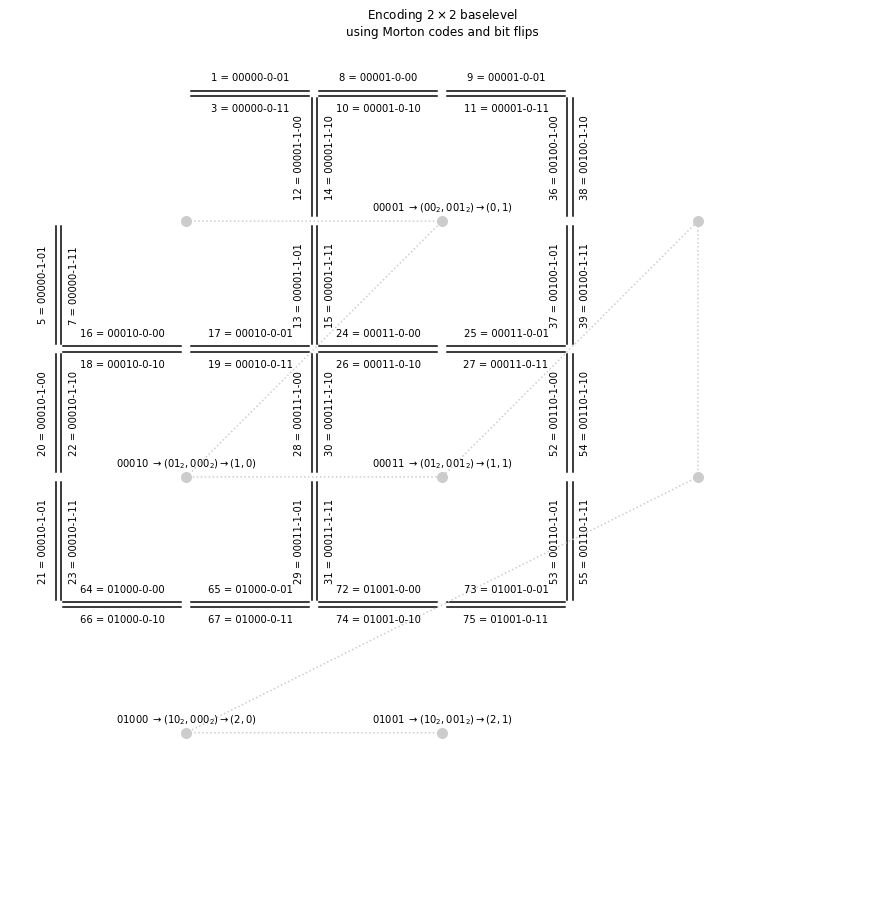

In [ ]:
m.plot()

In [ ]:
m1.print_alpha()

m1.print_custom()


Alpha_0 -> {1: 5, 3: 7, 5: 1, 7: 3}

Alpha_1 -> {}

Alpha_2 -> {}
{}
{}
{}


In [ ]:
m1._remove(0, 64)
m1.is_valid

d -> 64
d -> 64
d1 -> 65
d1 -> 67
d1 -> 20
d1 -> 22
dart that will be removed -> 64
delete -> 64
dart that will be removed -> 66
delete -> 66
dart that will be removed -> 21
delete -> 21
dart that will be removed -> 23
delete -> 23


True

In [ ]:
m1.print_alpha()

m1.print_custom()


Alpha_0 -> {1: 5, 3: 7, 5: 1, 7: 3, 65: 22, 67: 20, 20: 67, 22: 65}

Alpha_1 -> {}

Alpha_2 -> {}
{}
{}
{}


In [ ]:
m.impl_dict.plot()

AttributeError: 'implicit_dict' object has no attribute 'plot'

In [ ]:
m1._contract(1, 72)
m1.is_valid

d -> 72
i-cell -> {72, 73, 74, 75}
d1 -> 31
d1 -> 53
d1 -> 67
d1 -> 55
dart that will be removed -> 72
delete -> 72
dart that will be removed -> 73
delete -> 73
dart that will be removed -> 74
delete -> 74
dart that will be removed -> 75
delete -> 75


False

In [ ]:
m1.print_alpha()

m1.print_custom()


Alpha_0 -> {1: 5, 3: 7, 65: 22, 67: 20, 20: 67, 22: 65}

Alpha_1 -> {31: 53, 53: 31, 67: 55, 55: 67}

Alpha_2 -> {}
{}
{}
{}


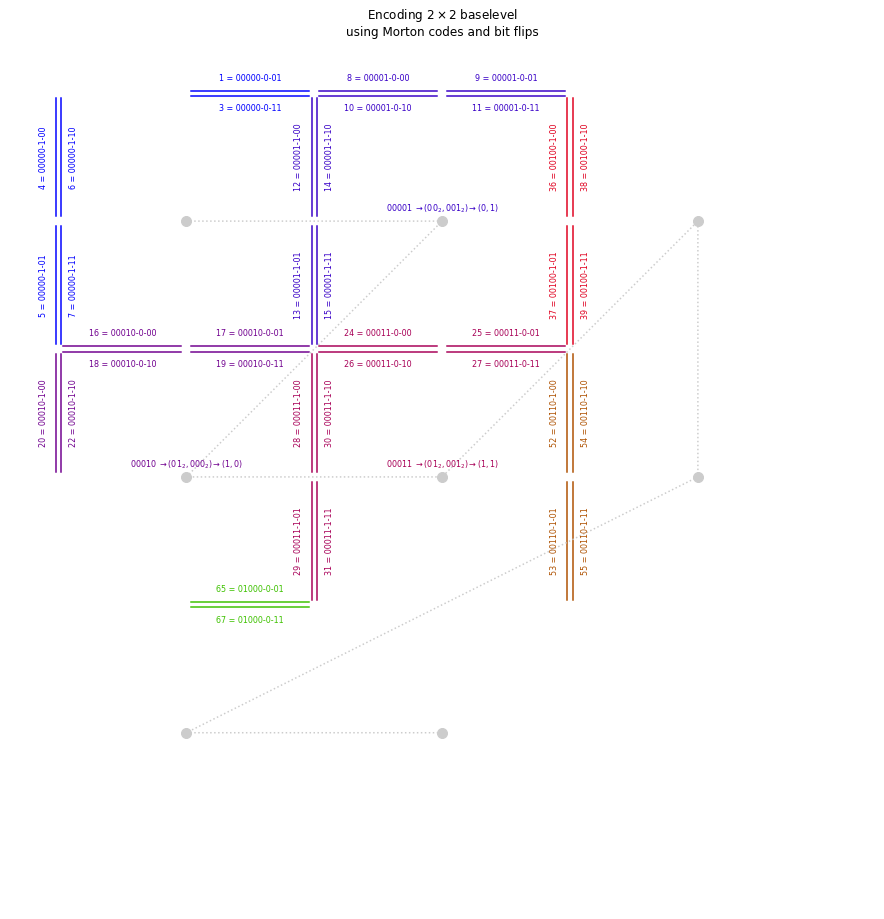

In [ ]:
m.impl_dict.plot()

In [ ]:
m1._contract(1, 67)
m1.is_valid

d -> 67
i-cell -> {65, 67, 20, 22}
d1 -> 29
d1 -> 55
d1 -> 5
d1 -> 18
dart that will be removed -> 65
delete -> 65
sto cancellando...
dart that will be removed -> 67
delete -> 67
sto cancellando...
sto cancellando...
dart that will be removed -> 20
delete -> 20
sto cancellando...
dart that will be removed -> 22
delete -> 22
sto cancellando...


False

In [ ]:
m1.print_alpha()

m1.print_custom()


Alpha_0 -> {1: 5, 3: 7}

Alpha_1 -> {31: 53, 53: 31, 55: 5, 29: 18, 5: 55, 18: 29}

Alpha_2 -> {}
{65: 22, 67: 20, 20: 67, 22: 65}
{}
{}


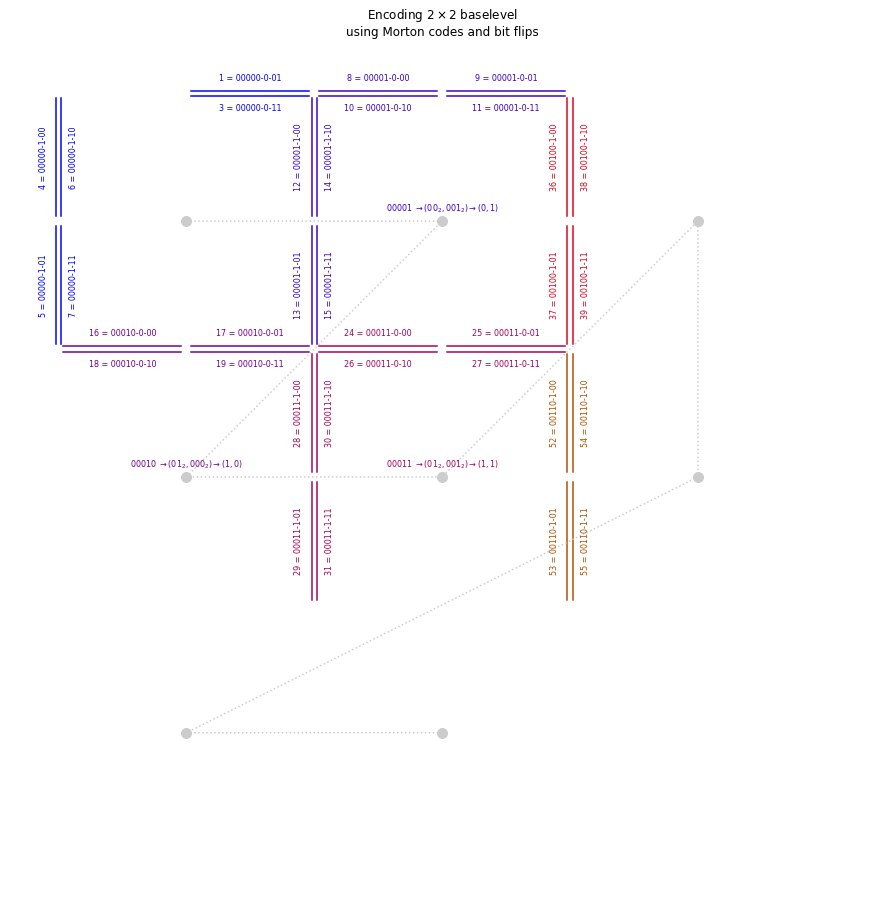

In [ ]:
m.impl_dict.plot()

In [ ]:
m1._insert_until_level(0)

dart 22 added to the set of darts
sono in custom
sono in custom
sto cancellando...
dart 20 added to the set of darts
sono in custom
sono in custom
sto cancellando...
dart 67 added to the set of darts
sono in custom
sono in custom
dart 65 added to the set of darts
sono in custom
sono in custom
sto cancellando...
dart 75 added to the set of darts
sto cancellando...
dart 74 added to the set of darts
dart 73 added to the set of darts
sto cancellando...
dart 72 added to the set of darts
sto cancellando...
dart 23 added to the set of darts
sto cancellando...
dart 21 added to the set of darts
sto cancellando...
dart 66 added to the set of darts
sto cancellando...
dart 64 added to the set of darts
sto cancellando...
dart 2 added to the set of darts
sto cancellando...
dart 0 added to the set of darts
sto cancellando...


In [ ]:
m1.print_alpha()

m1.print_custom()


Alpha_0 -> {}

Alpha_1 -> {}

Alpha_2 -> {}
{}
{}
{}


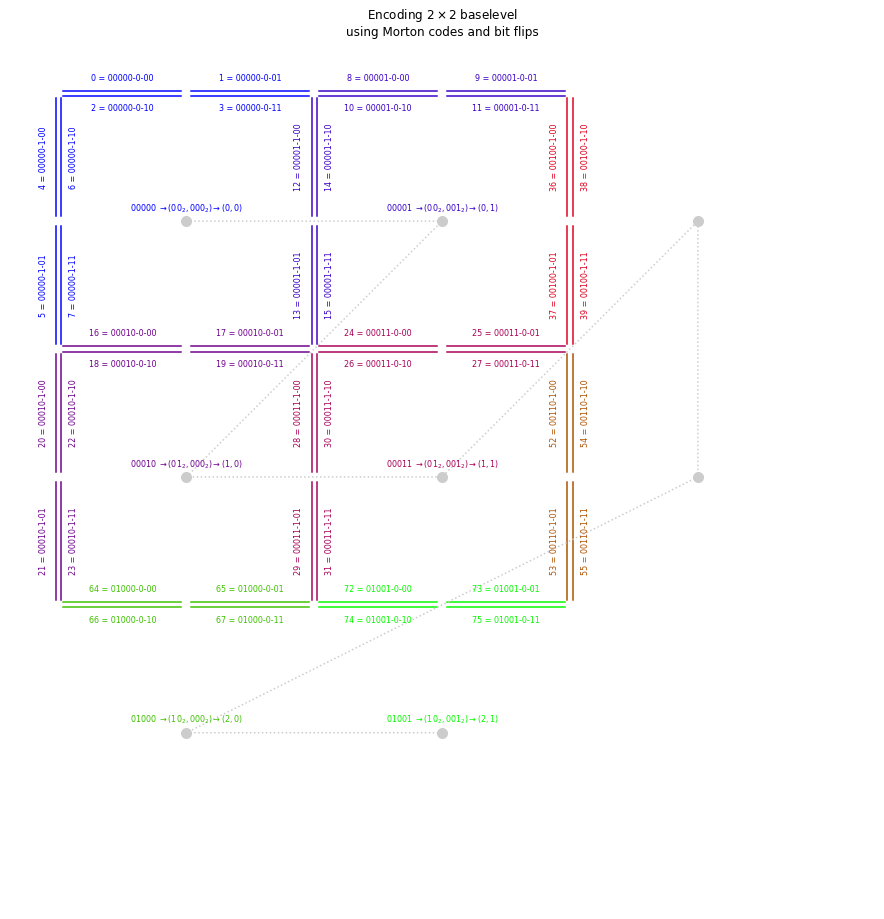

In [ ]:
m.impl_dict.plot()

In [ ]:
m1

2dGmap of 48 darts:
 0-cells: 9
 1-cells: 12
 2-cells: 5
 ccs: 1

In [ ]:
m1.print_final_alpha()


D[i]    |  1 | 0 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 2 | 21 | 20 | 22 | 24 | 25 | 26 | 27 | 28 | 29 | 30 | 31 | 23 | 36 | 37 | 38 | 39 | 52 | 53 | 54 | 55 | 64 | 67 | 65 | 66 | 72 | 73 | 74 | 75 | 
Alpha_0 |  0 | 1 | 2 | 5 | 4 | 7 | 6 | 9 | 8 | 11 | 10 | 13 | 12 | 15 | 14 | 17 | 16 | 19 | 18 | 3 | 20 | 21 | 23 | 25 | 24 | 27 | 26 | 29 | 28 | 31 | 30 | 22 | 37 | 36 | 39 | 38 | 53 | 52 | 55 | 54 | 65 | 66 | 64 | 67 | 73 | 72 | 75 | 74 | 
Alpha_1 |  8 | 4 | 12 | 0 | 20 | 2 | 16 | 1 | 38 | 14 | 36 | 3 | 17 | 10 | 24 | 7 | 13 | 22 | 28 | 6 | 66 | 5 | 18 | 15 | 37 | 30 | 52 | 19 | 65 | 26 | 72 | 64 | 11 | 25 | 9 | 54 | 27 | 73 | 39 | 75 | 23 | 74 | 29 | 21 | 31 | 53 | 67 | 55 | 
Alpha_2 |  3 | 2 | 1 | 6 | 7 | 4 | 5 | 10 | 11 | 8 | 9 | 14 | 15 | 12 | 13 | 18 | 19 | 16 | 17 | 0 | 23 | 22 | 20 | 26 | 27 | 24 | 25 | 30 | 31 | 28 | 29 | 21 | 38 | 39 | 36 | 37 | 54 | 55 | 52 | 53 | 66 | 65 | 67 | 64 | 74 | 75 | 72 | 73 | 